In [1]:
import pandas as pd
from pathlib import Path
import yaml
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
import importlib
from Orange.evaluation import scoring
_ = importlib.reload( scoring )

In [2]:
os.chdir('..')

## Data loading

In [140]:
ROOT_DIR: Path = Path('report/_MLP')
# ROOT_DIR: Path = Path('report/_liltab')

In [141]:
def load_metrics(root_path: str, parent_n: int = 1) -> pd.DataFrame:
    root_path = Path(root_path)
    
    metrics = pd.DataFrame()

    metrics_files = root_path.rglob("metrics.csv")
    for metric_file in metrics_files:
        data_name = metric_file
        for _ in range(parent_n):
            data_name = data_name.parent
        data_name = data_name.name
        
        exp = metric_file.parent.name

        metric_summary = pd.read_csv(metric_file)
        metric_summary["data_name"] = data_name
        metric_summary["exp"] = exp

        metrics = pd.concat([metrics, metric_summary])

    return metrics


def load_weights_summary(root_path: str, parent_n: int = 1) -> pd.DataFrame:
    summary_dfs = []

    weights_files = root_path.rglob("weights.csv")
    for weight_file in weights_files:
        data_name = weight_file
        for _ in range(parent_n):
            data_name = data_name.parent
        data_name = data_name.name
        
        experiment_name = weight_file.parent.name

        weights_summary = pd.read_csv(weight_file)

        test_weights = (
            weights_summary[weights_summary["type"] == "test_weights"]
            .iloc[:, 1:-1]
            .to_numpy()
        )
        target_test_weights = (
            weights_summary[
                weights_summary["type"] == "target_test_weights"
            ]
            .iloc[:, 1:-1]
            .to_numpy()
        )

        diffs = test_weights - target_test_weights
        norm_l2 = np.linalg.norm(diffs)
        std_res = np.std(test_weights, axis=0).mean()
        std_target = np.std(target_test_weights, axis=0).mean()

        summary_df = pd.DataFrame(
            data={
                "data_name": [data_name],
                "experiment_name": [experiment_name],
                "diff_norm": [norm_l2],
                "std": [std_res],
                "std_target": [std_target],
            }
        )
        summary_dfs.append(summary_df)

    summary = pd.concat(summary_dfs)
    return summary

def load_meta_data(root_path: str, parent_n: int = 1) -> pd.DataFrame:
    root_path = Path(root_path)
    
    meta = pd.DataFrame()

    meta_files = root_path.rglob("meta_data.yaml")
    for meta_file in meta_files:
        data_name = meta_file
        for _ in range(parent_n):
            data_name = data_name.parent
        data_name = data_name.name
        
        exp = meta_file.parent.name

        with open(meta_file) as f:
            info = yaml.safe_load(f)
        
        row = pd.DataFrame({
            'data_name': [info['data']['data_name']],
            'n_features': [info['data']['n_features']],
            'train_size': [info['data']['train_size']],
            'weights': [info['models']['weights']],
            'n_models': [info['models']['n']],
            'step_size': [info['reweighter']['step_size']],
            'step_size_test_optim': [info['reweighter']['step_size_test_optim']],
            'exp_name': [exp],
        })
        
        meta = pd.concat([meta, row])
        
    meta.drop_duplicates(['data_name'], inplace=True)


    return meta

In [142]:
metrics = load_metrics(ROOT_DIR, parent_n=2)
weights = load_weights_summary(ROOT_DIR, parent_n=2)
meta = load_meta_data(ROOT_DIR)

In [143]:
def retreive_alpha(exp):
    exp_alpha = exp[-exp[::-1].find('='):]
    return float(exp_alpha)

metrics['alpha'] = metrics['exp'].apply(retreive_alpha)

## Normalized metrics

In [144]:
upper_bound = metrics[metrics['type'] == 'upper_bound']
lower_bound = metrics[metrics['type'] == 'static']

metrics = metrics[metrics['data'] == 'test']
dynamic_metrics = metrics[metrics['type'] == 'dynamic']

metrics_norm = pd.merge(dynamic_metrics, upper_bound, on=['metric', 'data_name'])
metrics_norm.rename(columns={'score_y': 'upper_bound'}, inplace=True)
metrics_norm.rename(columns={col: col[:-2] for col in metrics_norm.columns if '_x' in col}, inplace=True)
metrics_norm.drop(columns=[col for col in metrics_norm.columns if '_y' in col], inplace=True)

metrics_norm = pd.merge(metrics_norm, lower_bound, on=['metric', 'data', 'data_name'])
metrics_norm.rename(columns={'score_y': 'lower_bound'}, inplace=True)
metrics_norm.rename(columns={col: col[:-2] for col in metrics_norm.columns if '_x' in col}, inplace=True)
metrics_norm.drop(columns=[col for col in metrics_norm.columns if '_y' in col], inplace=True)

metrics_norm['norm_score'] = (metrics_norm['score'] - metrics_norm['lower_bound']) \
    / (metrics_norm['upper_bound'] - metrics_norm['lower_bound'])

In [145]:
print(f'Dynamic approach made a difference in {(metrics_norm["norm_score"] != 0).mean():.2f} tasks')

Dynamic approach made a difference in 0.62 tasks


/tmp/ipykernel_42246/2126344132.py:5: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  ax = sns.boxplot(data=metrics_norm,


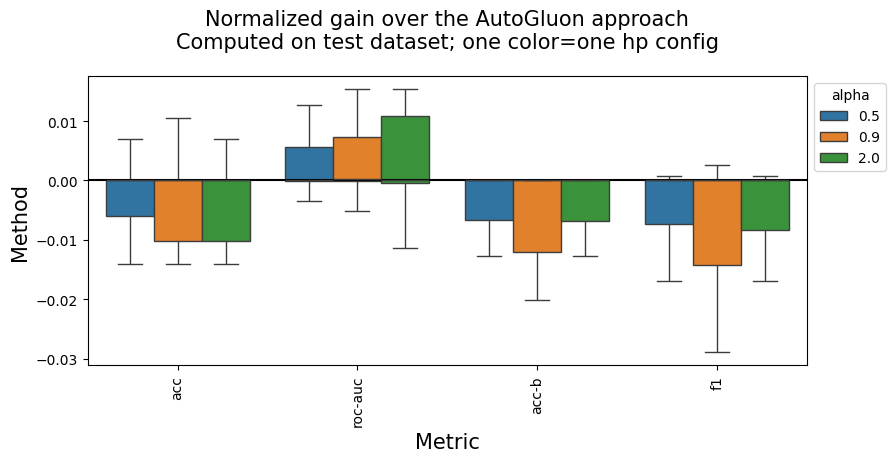

In [146]:
df_temp = pd.merge(meta, metrics_norm, on='data_name')

plt.figure(figsize=(9, 4))

ax = sns.boxplot(data=metrics_norm,
                x='metric',
                y='norm_score',
                hue='alpha',
                legend=True,
                palette=sns.color_palette("tab10"),
                showfliers=False
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.xticks(rotation=90)
plt.tight_layout()
plt.axhline(0, color='black')
plt.xlabel('Metric', fontsize=15)
plt.ylabel('Method', fontsize=15)
plt.title('Normalized gain over the AutoGluon approach\nComputed on test dataset; one color=one hp config', fontsize=15, pad=20)

plt.show()

Above, $1.00$ score is maximal possible gain given the models. Score $0.00$ means no difference between AutogGluon and static approach. Negative score means worse performance than AutoGluon.

## Weights diversity

/tmp/ipykernel_42246/3253576946.py:12: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  ax = sns.boxplot(data=weights_melted,


Text(0.5, 1.0, 'Diversity of weights measured by std, compared to target diversity')

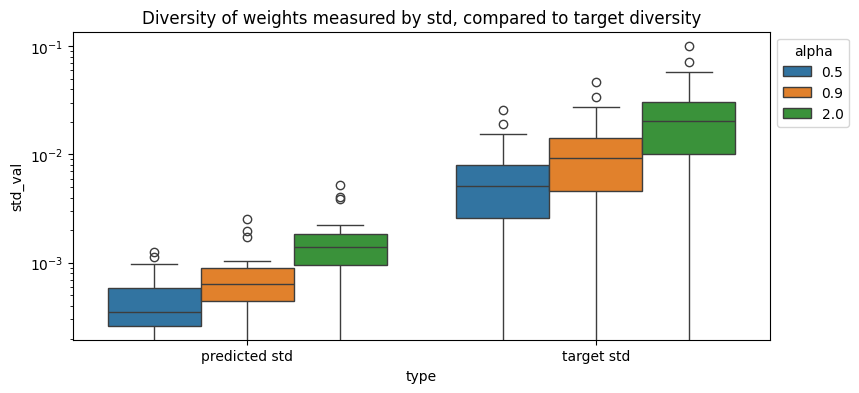

In [10]:
weights['alpha'] = weights['experiment_name'].apply(retreive_alpha)

plt.figure(figsize=(9, 4))

weights_melted = pd.melt(weights, id_vars=['alpha'],
                         value_vars=['std', 'std_target'],
                         var_name='type',
                         value_name='std_val')

weights_melted['type'] = weights_melted['type'].apply(lambda name: 'predicted std' if name == 'std' else 'target std')
import importlib
from Orange.evaluation import scoring
_ = importlib.reload( scoring )
ax = sns.boxplot(data=weights_melted, 
                 x='type',
                 y='std_val',
                hue='alpha',
                legend=True,
                palette=sns.color_palette("tab10")
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

ax.set_yscale('log')

plt.title('Diversity of weights measured by std, compared to target diversity')

## Static models diversity 

In [11]:
def entropy_normalized(weights: list[float]) -> float:
    if len(weights) == 1:
        return 0
    entropy = np.sum(np.log(weights) * weights)
    norm_entropy = entropy / np.log(len(weights))
    return norm_entropy

Text(0.5, 1.0, 'Static models normalized entropy\n0=>one model, -1=>$weights=(\\frac{1}{k},\\dots,\\frac{1}{k})$')

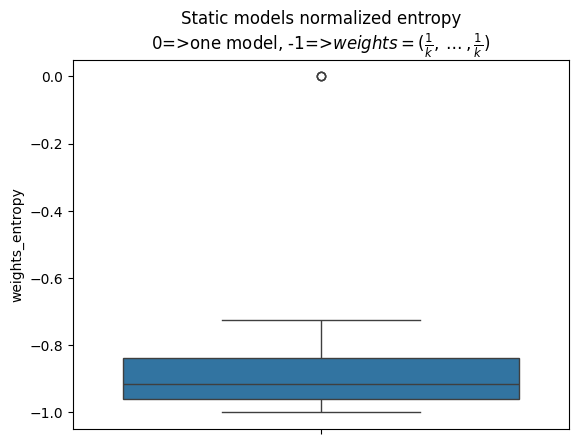

In [12]:
meta['weights_entropy'] = meta['weights'].apply(entropy_normalized)

sns.boxplot(data=meta, y='weights_entropy')
plt.title('Static models normalized entropy\n'r'0=>one model, -1=>$weights=(\frac{1}{k},\dots,\frac{1}{k})$')

## Cross analysis

In [13]:
df_merge = pd.merge(meta, metrics_norm, on='data_name')
df_merge = df_merge[df_merge['metric'] == 'roc-auc']

df_merge = pd.merge(df_merge, weights, left_on=['data_name', 'exp', 'alpha'], right_on=['data_name', 'experiment_name', 'alpha'])

/tmp/ipykernel_42246/1949293197.py:3: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  ax = sns.scatterplot(data=df_merge,


Text(0.5, 1.0, 'Dependence between dataset size and final score')

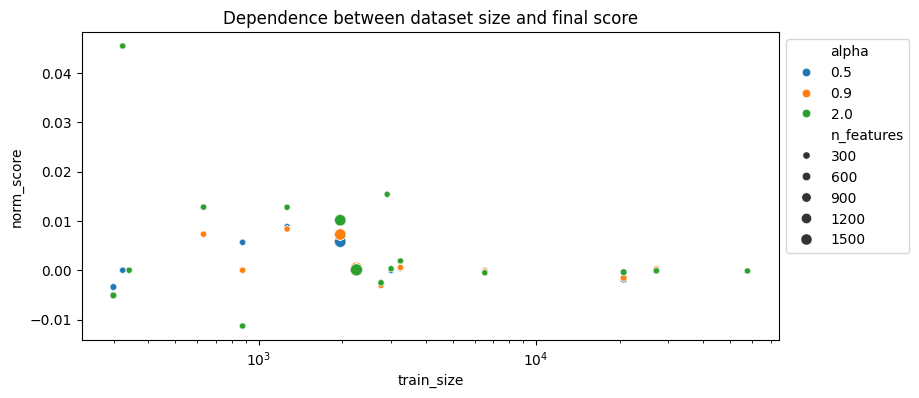

In [49]:
plt.figure(figsize=(9, 4))

ax = sns.scatterplot(data=df_merge,
                x='train_size',
                y='norm_score',
                size='n_features',
                hue='alpha',
                legend=True,
                palette=sns.color_palette("tab10")
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xscale('log')

plt.title('Dependence between dataset size and final score')

/tmp/ipykernel_42246/2972390636.py:3: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  ax = sns.scatterplot(data=df_merge,


Text(0.5, 1.0, 'Dependence between static model entropy and final score')

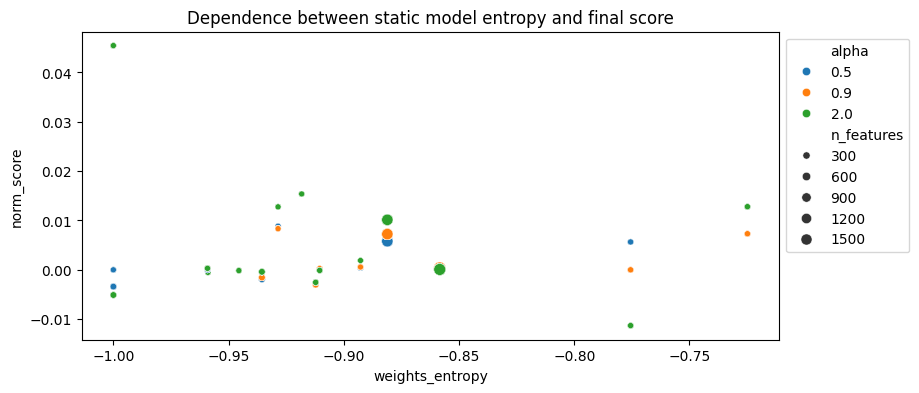

In [15]:
plt.figure(figsize=(9, 4))

ax = sns.scatterplot(data=df_merge,
                x='weights_entropy',
                y='norm_score',
                size='n_features',
                hue='alpha',
                legend=True,
                palette=sns.color_palette("tab10")
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.title('Dependence between static model entropy and final score')

/tmp/ipykernel_42246/1107315969.py:3: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  ax = sns.scatterplot(data=df_merge,


Text(0.5, 1.0, 'Dependence between dataset size and diversity of predictions')

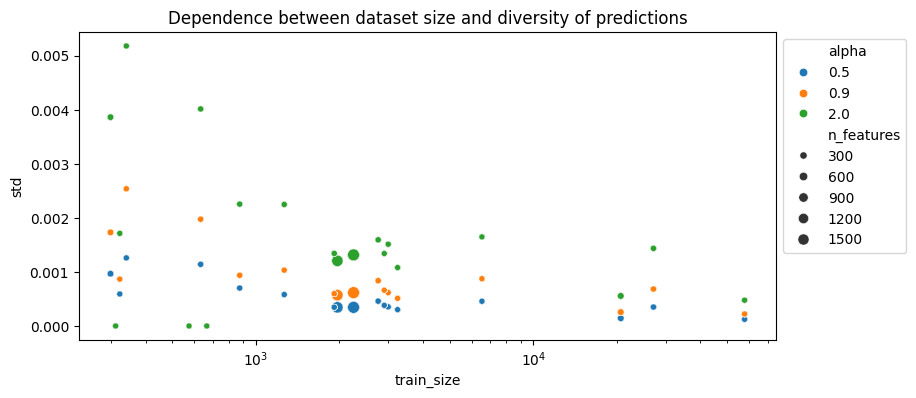

In [48]:
plt.figure(figsize=(9, 4))

ax = sns.scatterplot(data=df_merge,
                x='train_size',
                y='std',
                size='n_features',
                hue='alpha',
                legend=True,
                palette=sns.color_palette("tab10")
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xscale('log')

plt.title('Dependence between dataset size and diversity of predictions')

/tmp/ipykernel_42246/1540191157.py:3: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  ax = sns.scatterplot(data=df_merge,


Text(0.5, 1.0, 'Dependence between prediction diversity and final score')

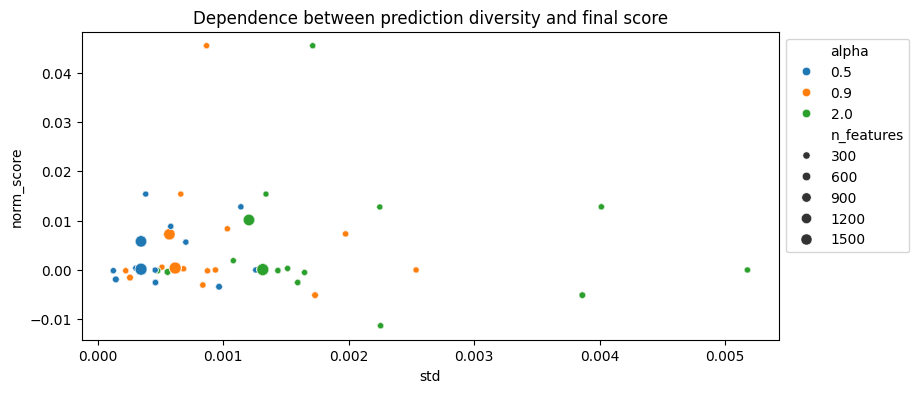

In [17]:
plt.figure(figsize=(9, 4))

ax = sns.scatterplot(data=df_merge,
                x='std',
                y='norm_score',
                size='n_features',
                hue='alpha',
                legend=True,
                palette=sns.color_palette("tab10")
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.title('Dependence between prediction diversity and final score')

/tmp/ipykernel_42246/727398660.py:3: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  ax = sns.scatterplot(data=df_merge,


Text(0.5, 1.0, 'Dependence between prediction diversity and final score')

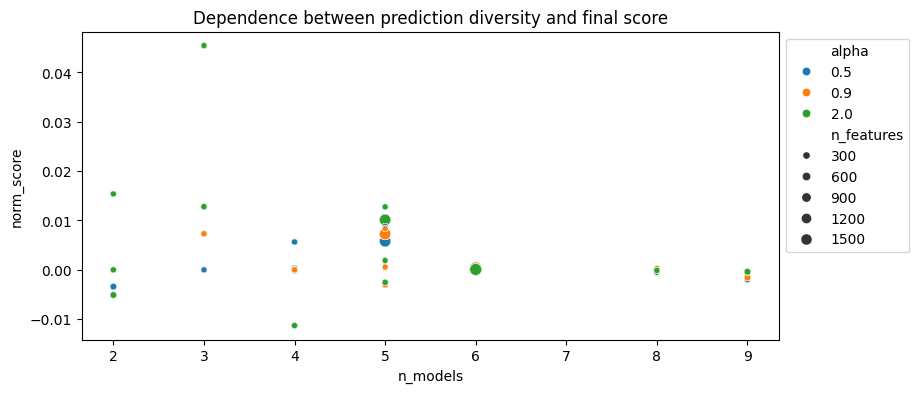

In [18]:

plt.figure(figsize=(9, 4))

ax = sns.scatterplot(data=df_merge,
                x='n_models',
                y='norm_score',
                size='n_features',
                hue='alpha',
                legend=True,
                palette=sns.color_palette("tab10")
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.title('Dependence between prediction diversity and final score')

In [50]:
metrics_norm.head()

,metric,data,score,type,data_name,exp,alpha,upper_bound,lower_bound,norm_score,rank
0,acc,test,0.967988,dynamic,Internet-Advertisements,"MLPEncoder;shape=[200, 200, 200]_DirectionRewe...",0.5,0.981707,0.967988,0.0,68.0
1,acc,test,0.967988,dynamic,Internet-Advertisements,"MLPEncoder;shape=[200, 200, 200]_DirectionRewe...",0.5,0.981707,0.967988,0.0,68.0
2,acc,test,0.967988,dynamic,Internet-Advertisements,"MLPEncoder;shape=[200, 200, 200]_DirectionRewe...",0.5,0.981707,0.967988,0.0,68.0
3,acc,test,0.967988,dynamic,Internet-Advertisements,"MLPEncoder;shape=[200, 200, 200]_DirectionRewe...",0.5,0.981707,0.967988,0.0,68.0
4,acc,test,0.967988,dynamic,Internet-Advertisements,"MLPEncoder;shape=[200, 200, 200]_DirectionRewe...",0.5,0.981707,0.967988,0.0,68.0


/tmp/ipykernel_42246/2097740809.py:6: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  ax = sns.scatterplot(data=df_merge[df_merge['data_name'].isin(data_name_easy)],


Text(0.5, 1.0, 'Dependence between prediction diversity and final score')

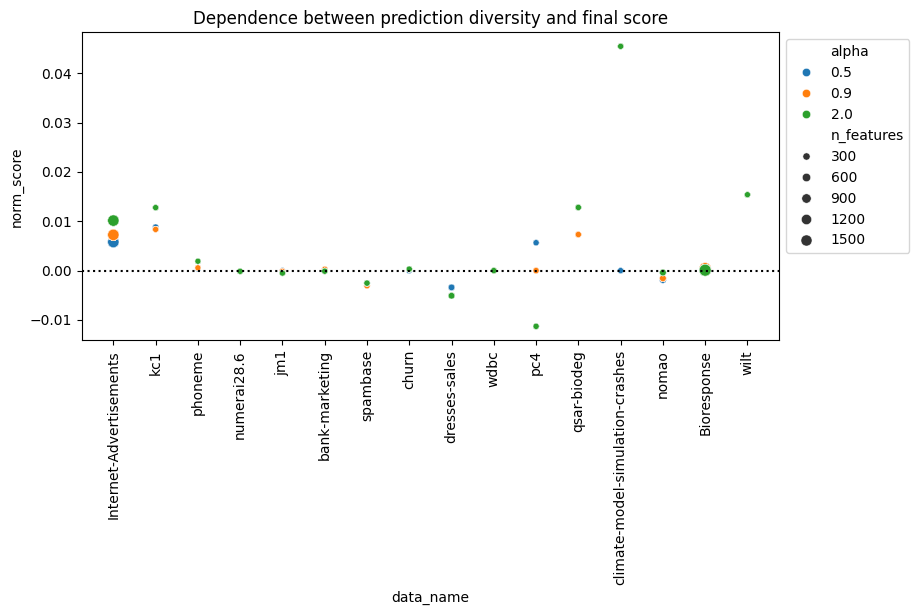

In [63]:

data_easy = metrics_norm[(metrics_norm['upper_bound'] - metrics_norm['lower_bound']) > 1e-3]
data_name_easy = np.unique(data_easy['data_name'])

plt.figure(figsize=(9, 4))

ax = sns.scatterplot(data=df_merge[df_merge['data_name'].isin(data_name_easy)],
                x='data_name',
                y='norm_score',
                size='n_features',
                hue='alpha',
                legend=True,
                palette=sns.color_palette("tab10")
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)
plt.axhline(y=0, c='black').set_linestyle('dotted')

plt.title('Dependence between prediction diversity and final score')

0.6489920306019944


/tmp/ipykernel_42246/1741104315.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_norm_temp['rank'] = metrics_norm_temp.groupby("data_name")["score"].rank(method="dense", ascending=False)
/tmp/ipykernel_42246/1741104315.py:10: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = scoring.compute_CD(avranks, datasets_n, alpha="0.1")
/tmp/ipykernel_42246/1741104315.py:12: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  scoring.graph_ranks(avranks, names, cd, width=6, textspace=1.5)


Text(0.5, 1.0, 'Critical Distance - comparison of alpha HP')

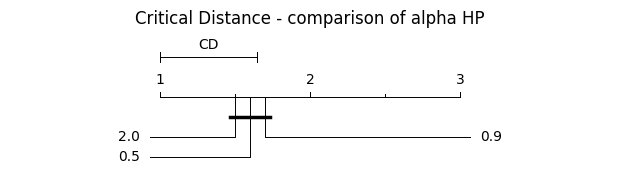

In [47]:
metrics_norm_temp = metrics_norm[metrics_norm['metric'] == 'roc-auc']
metrics_norm_temp['rank'] = metrics_norm_temp.groupby("data_name")["score"].rank(method="dense", ascending=False)
# acc_b = acc_b[acc_b['rank'] != 1.5]
avg_ranks = metrics_norm_temp.groupby('alpha')['rank'].mean()


names = avg_ranks.index.tolist()
avranks =  avg_ranks.values.tolist()
datasets_n = np.unique(metrics['data_name']).shape[0]
cd = scoring.compute_CD(avranks, datasets_n, alpha="0.1")
print(cd)
scoring.graph_ranks(avranks, names, cd, width=6, textspace=1.5)
plt.title('Critical Distance - comparison of alpha HP')
